In [216]:
# librairies
import pandas as pd
import numpy as np 
import string 
import sys
import os 

# for visualization 
# Plot confusion matrix
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix
from matplotlib.pyplot import figure
import seaborn as sn

In [217]:
import re
import gensim
import nltk
import keras
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import Input
from keras.layers.merge import concatenate
from keras.models import Model
from keras.callbacks import ModelCheckpoint

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [218]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [219]:
%cd drive/MyDrive/Colab

[Errno 2] No such file or directory: 'drive/MyDrive/Colab'
/content/drive/MyDrive/Colab


## Processing the data 


In [146]:
# import the dataset

# Path Kodjo
# path = '/home/anselme/Desktop/Etude/MVA_S1/DL/MVA_DL/Data Mining'

dataset = pd.read_excel('dataset.xlsx', skiprows=0)

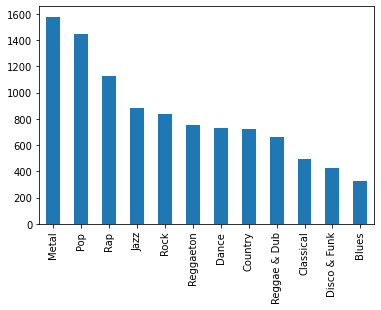

In [220]:
dataset['Class'].value_counts().plot(kind='bar')
plt.show()

In [222]:
from sklearn.utils import shuffle
dataset = shuffle(dataset)

dataset

,Name,Artist,Album,Release Date,Lyrics,Class
27,You Know Me,2 Pistols,Death Before Dishonor,2008-01-01,"Ooooh Ooooh, Ooooh Ooooh\nOoooh Ooooh, Ooooh O...",Rap
3325,BREAK UP,Feid,BAHÍA DUCATI,2020-09-11,"[Letra de ""BREAK UP""]\n\n[Intro: De La Ghetto]...",Reggaeton
280,Work,Alborosie,Soul Pirate (Deluxe Remastered Edition),2015-02-10,"[verse 1: Alborosie]\nGood Morning Mama Jam, I...",Reggae & Dub
5606,Milkshake,Kelis,Tasty,2003-12-05,[Chorus]\nMy milkshake brings all the boys to ...,Pop
157,Take Me to the Top,Advance,Take Me to the Top,1983,"We can talk about it, what's been done is gone...",Disco & Funk
...,...,...,...,...,...,...
8444,Have I Got Blues for You,Snowy White,Reunited,2017-10-06,[Verse 1]\nThe jingle bells are jingling\nThe ...,Blues
5141,Foxey Lady,Jimi Hendrix,Are You Experienced,1967-05-12,"[Verse]\nFoxy, Foxy\nYou know you're a cute li...",Rock
2892,Can‘t Stop Raving,Dune,Dune,1995-08-01,I can't stop raving\nI can't stop raving\nI ca...,Dance
6285,Sunshine,Lupe Fiasco,Lupe Fiasco's Food & Liquor (5th Anniversary E...,2006-06-27,[Verse 1]\nFresh to def she is\nFrom her steps...,Rap


In [223]:
# Process lyrics
dataset["Lyrics"] = dataset["Lyrics"].str.replace('chorus','')

# Lyrics
Lyrics = [dataset['Lyrics'][i] for i in range(dataset.shape[0])]

# labels 
yData  = [dataset['Class'][i]  for i in range(dataset.shape[0])]


# remove text between [] (corresponds to Chrous / verse headings)
Lyrics = [re.sub("\[.*?\]", "",Lyrics[i]) for i in range( dataset.shape[0])]

# Clean up data (replace \n, [, (, ], ) par "")
Lyrics = [Lyrics[i].replace('\n', ' ') for i in  range( dataset.shape[0])]
Lyrics = [Lyrics[i].replace('[' ,  '') for i in  range( dataset.shape[0])]
Lyrics = [Lyrics[i].replace(']' ,  '') for i in  range( dataset.shape[0])]
Lyrics = [Lyrics[i].replace('(' ,  '') for i in  range( dataset.shape[0])]
Lyrics = [Lyrics[i].replace(')' ,  '') for i in  range( dataset.shape[0])]

#for i in range(100):
#  print(Lyrics[i])

xData = []
stop_words = set(stopwords.words('english'))
translator = str.maketrans('', '', string.punctuation)

for Lyric in Lyrics:
    # Tokenize each lyric, and set all characters to lower-case
    tokens = word_tokenize(Lyric)
    tokens = [word.lower() for word in tokens]
    
    # Remove punctuation
    tokens_nopunc = [word.translate(translator) for word in tokens]
    
    # Remove non-alphabetic tokens
    words = [word for word in tokens_nopunc if word.isalpha()]
    
    # Remove stop words from the lyric
    words = [word for word in words if not word in stop_words]
    
    # Append to training data
    xData.append(words)

for i in range(100):
  print(xData[i])

['hot', 'hot', 'l', 'let', 'tell', 'wan', 'na', 'let', 'show', 'feelin', 'wan', 'na', 'freak', 'wan', 'na', 'ride', 'wan', 'na', 'taste', 'wan', 'na', 'put', 'lips', 'ca', 'nt', 'get', 'enough', 'always', 'sweet', 'ca', 'nt', 'forget', 'good', 'girl', 'make', 'sweat', 'girl', 'talkin', 'bout', 'peaches', 'cream', 'oooh', 'need', 'cause', 'know', 'fiend', 'right', 'gettin', 'freaky', 'bentley', 'limousine', 'even', 'better', 'ice', 'cream', 'know', 'mean', 'peaches', 'cream', 'need', 'cause', 'know', 'fiend', 'gettin', 'freaky', 'bentley', 'limousine', 'even', 'better', 'ice', 'cream', 'girl', 'taste', 'good', 'know', 'mean', 'peaches', 'cream', 'never', 'thought', 'would', 'addicted', 'top', 'underneath', 'side', 'better', 'yet', 'baby', 'right', 'next', 'love', 'way', 'flowin', 'feel', 'around', 'front', 'back', 'ooh', 'love', 'smell', 'girl', 'know', 'talking', 'hook', 'q', 'peaches', 'cream', 'need', 'cause', 'know', 'fiend', 'ooh', 'gettin', 'freaky', 'bentley', 'limousine', 'ooohh

In [224]:
# Loads pre-trained GloVe word embeddings

# Load in GloVe file and initialize embedding index
filename = 'glove.6B.300d.txt'
file = open(os.path.join('', filename), encoding = "utf-8")
embeddings_index = {}

for line in file:
   
    # Add each embedding to the embedding index
    embedding = line.split()
    embeddings_index[embedding[0]] = np.asarray(embedding[1:])

file.close()

In [225]:
# Map each word token in the training data to an integer

# For each training example, maps each word token to an integer
tokenizer = Tokenizer() 
tokenizer.fit_on_texts(xData)
xData_seq = tokenizer.texts_to_sequences(xData)

In [226]:
# Pad sequences shorter than max length 
max_num_tokens = max([len(tokenized_lyric) for tokenized_lyric in xData])
xData_seq_padded = pad_sequences(xData_seq, maxlen=max_num_tokens)

In [227]:
# Map GloVe word embeddings to each word in the tokenizer word index to create a matrix of word embeddings

# Initialize embedding matrix
EMBEDDING_DIM = 300
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

# Populate embedding matrix
for word, i in word_index.items():
    
    if i > num_words:
        continue
        
    # Assign corresponding GloVe embedding to the given word
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        # Words not found in the embedding are assigned a zero vector by default
        embedding_matrix[i] = embedding_vector

In [228]:
# Shuffles the data, and splits it into train and test sets
np.random.seed(0)

VALIDATION_SPLIT = 0.1
word_indices = np.arange(xData_seq_padded.shape[0])
np.random.shuffle(word_indices)
xData_seq_padded = xData_seq_padded[word_indices]
mood = np.array(yData)
mood = mood[word_indices]

# Binarizes the mood labels
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
moods = encoder.fit_transform(mood.tolist())

# Splits the dataset into train and test sets
num_validation_samples = int(VALIDATION_SPLIT * xData_seq_padded.shape[0])

X_train_pad = xData_seq_padded[:-(2 * num_validation_samples)]
y_train = moods[:-(2 * num_validation_samples)]

X_val_pad = xData_seq_padded[-(2 * num_validation_samples):-num_validation_samples]
y_val = moods[-(2 * num_validation_samples):-num_validation_samples]

X_test_pad = xData_seq_padded[-num_validation_samples:]
y_test = moods[-num_validation_samples:]

print("Train set length: {}".format(len(X_train_pad)))
print("Validation set length: {}".format(len(X_val_pad)))
print("Test set length: {}".format(len(X_test_pad)))

Train set length: 8000
Validation set length: 1000
Test set length: 1000


In [229]:
# Defines the Multiclass model, compiles and trains it

model = Sequential()
embedding_layer = Embedding(num_words, 
                            EMBEDDING_DIM, 
                            embeddings_initializer=Constant(embedding_matrix), 
                            input_length=max_num_tokens,
                            trainable=False)

model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(Conv1D(256, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(48, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(12, activation='softmax'))

checkpoint_filepath = 'checkpoint1'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    save_freq='epoch',
    verbose=1)

op = keras.optimizers.Adam(learning_rate = 0.0001)
model.compile(optimizer= op, loss='categorical_crossentropy', metrics=['accuracy'])

print(model.summary())

# Saves a History object for plotting
history = model.fit(X_train_pad, y_train, batch_size=16, epochs=30, 
                    validation_data=(X_val_pad, y_val), verbose=2, callbacks=[model_checkpoint_callback])

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_86 (Embedding)     (None, 1702, 300)         20604600  
_________________________________________________________________
dropout_105 (Dropout)        (None, 1702, 300)         0         
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 1698, 256)         384256    
_________________________________________________________________
global_max_pooling1d_59 (Glo (None, 256)               0         
_________________________________________________________________
dense_200 (Dense)            (None, 48)                12336     
_________________________________________________________________
dense_201 (Dense)            (None, 24)                1176      
_________________________________________________________________
dense_202 (Dense)            (None, 12)              

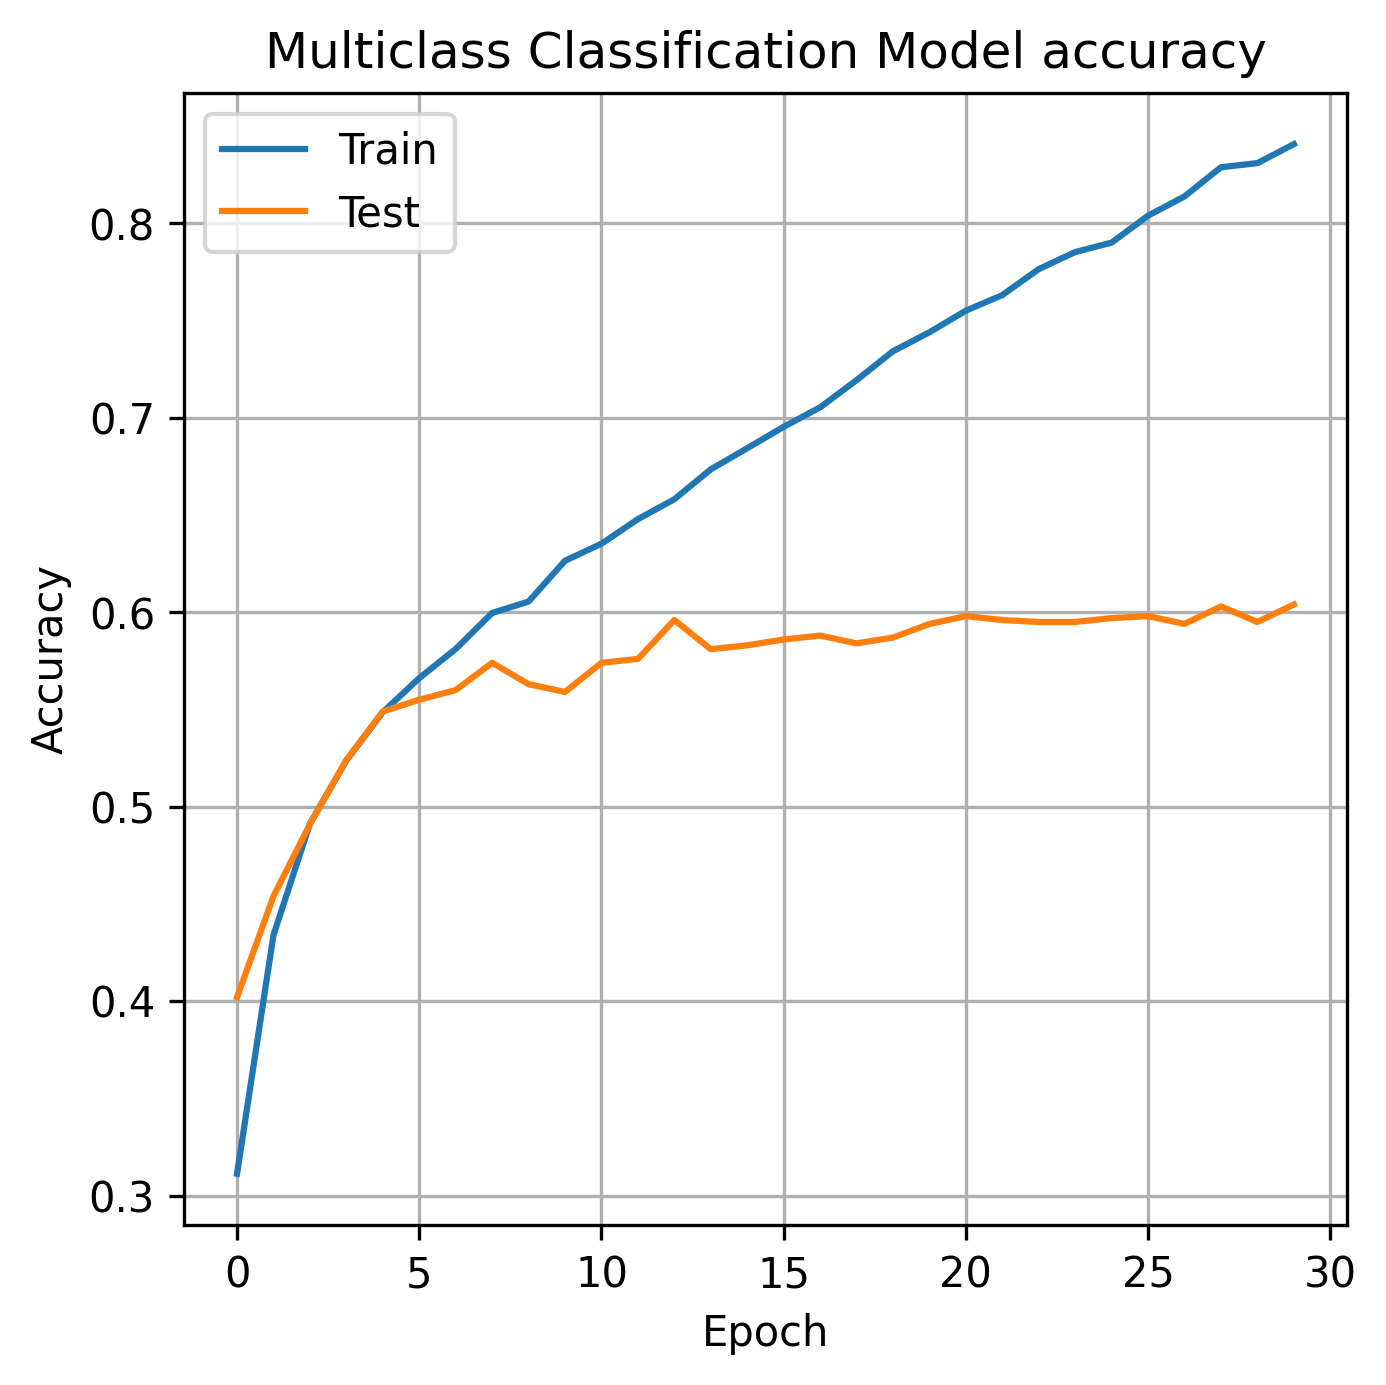

In [230]:
# Plot accuracy as a function of training epoch

figure(num=None, figsize=(5, 5), dpi=300)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(True)
plt.title('Multiclass Classification Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [231]:
model.load_weights(checkpoint_filepath)

results = model.evaluate(X_test_pad, y_test, batch_size=16)
print("test loss, test acc:", results)

print(model.summary())

63/63 [==============================] - 1s 15ms/step - loss: 1.2508 - accuracy: 0.6060
test loss, test acc: [1.2507613897323608, 0.6060000061988831]
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_86 (Embedding)     (None, 1702, 300)         20604600  
_________________________________________________________________
dropout_105 (Dropout)        (None, 1702, 300)         0         
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 1698, 256)         384256    
_________________________________________________________________
global_max_pooling1d_59 (Glo (None, 256)               0         
_________________________________________________________________
dense_200 (Dense)            (None, 48)                12336     
_________________________________________________________________
dense_201 (Dense)            (None,

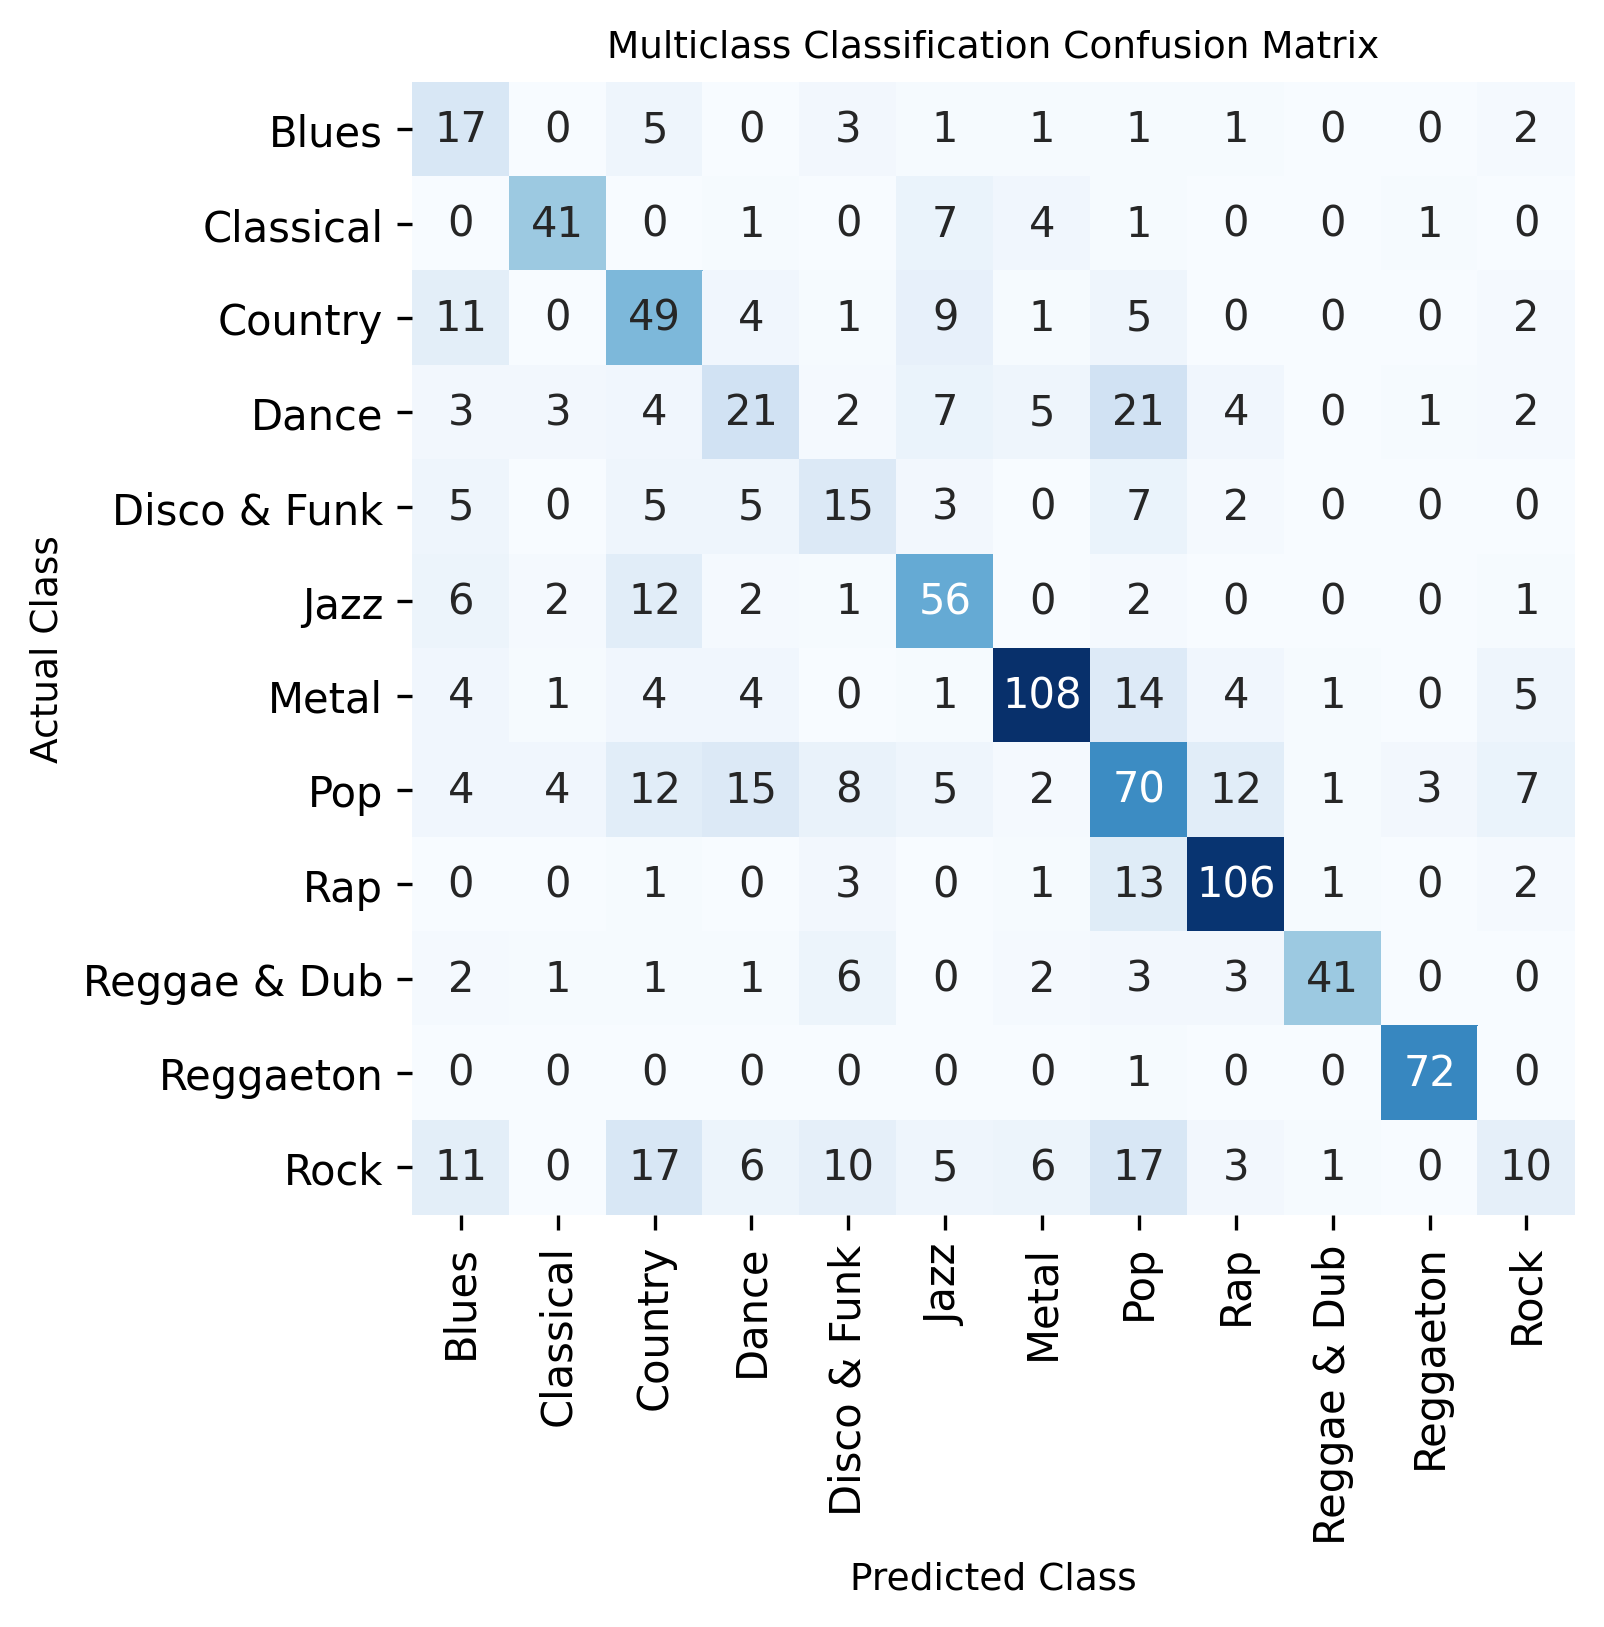

In [232]:
# Plot confusion matrix
alphabetical = []

for el in mood:
    if (el not in alphabetical):
        alphabetical.append(el)

alphabetical = sorted(alphabetical)

# Gets predicted labels from model
y_pred = model.predict(X_test_pad)

# Formats labels into appropriate class designations
y_pred_classes = np.zeros(len(y_pred)).astype(int)
y_test_classes = np.zeros(len(y_test)).astype(int)

for index, label in enumerate(y_pred):
    y_pred_classes[index] = np.argmax(y_pred[index])
    
for index, label in enumerate(y_test):
    y_test_classes[index] = np.argmax(y_test[index])

# Generates confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Formats and displays the confusion matrix
figure(num=None, figsize=(5, 5), dpi=300)
df_cm = pd.DataFrame(cm, index = alphabetical, columns = alphabetical)
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap=plt.cm.Blues, fmt='g', cbar=False)
plt.title('Multiclass Classification Confusion Matrix', fontsize=9)
plt.xlabel("Predicted Class", fontsize=9)
plt.ylabel("Actual Class", fontsize=9)
plt.show()

In [233]:
# Cell for getting information about each class

from sklearn.metrics import classification_report

new_test_classes = np.full(shape=y_test_classes.shape[0], fill_value="yoooooooooooooooo")
new_pred_classes = np.full(shape=y_pred_classes.shape[0], fill_value="yoooooooooooooooo")


for x in range(len(y_test_classes)):
    id1 = y_test_classes[x]
    id2 = y_pred_classes[x]

    word1 = alphabetical[id1]
    word2 = alphabetical[id2]

    new_test_classes[x] = word1
    new_pred_classes[x] = word2

print(classification_report(new_test_classes, new_pred_classes))

              precision    recall  f1-score   support

       Blues       0.27      0.55      0.36        31
   Classical       0.79      0.75      0.77        55
     Country       0.45      0.60      0.51        82
       Dance       0.36      0.29      0.32        73
Disco & Funk       0.31      0.36      0.33        42
        Jazz       0.60      0.68      0.64        82
       Metal       0.83      0.74      0.78       146
         Pop       0.45      0.49      0.47       143
         Rap       0.79      0.83      0.81       127
Reggae & Dub       0.91      0.68      0.78        60
   Reggaeton       0.94      0.99      0.96        73
        Rock       0.32      0.12      0.17        86

    accuracy                           0.61      1000
   macro avg       0.58      0.59      0.57      1000
weighted avg       0.61      0.61      0.60      1000

